### Hồi quy đa thức
- Để có thể hình dung một cách trực quan hơn về mối quan hệ giữa quá khớp và độ phức tạp mô hình, ta sẽ đưa ra một ví dụ sử dụng đa thức. Cho một tập dữ liệu huấn luyện có một đặc trưng duy nhất là một số thực x và nhãn y tương ứng có giá trị thực, ta thử chọn bậc d của đa thức để ước tính nhãn y.

    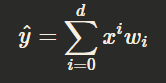
- Đây đơn giản là một bài toán hồi quy tuyến tính trong đó các đặc trưng được tính bằng cách lấy mũ của x theo từng bậc, w_i là trọng số của mô hình, và w0 là hệ số điều chỉnh.
- Vì đây là bài toán hồi quy tuyến tính lên ta có thể sử dụng bình phương sai số hàm mất mát.
- Hàm đa thức bậc cao phức tạp hơn hàm đa thức bậc thấp, vì đa thức bậc cao có nhiều tham số hơn và miền lựa chọn hàm số cũng rộng hơn. Nếu giữ nguyên tập dữ liệu huấn luyện thì các hàm đa thức bậc cao hơn bao giờ cũng đạt được lỗi huấn luyện thấp hơn hàm đa thức bậc thấp. 
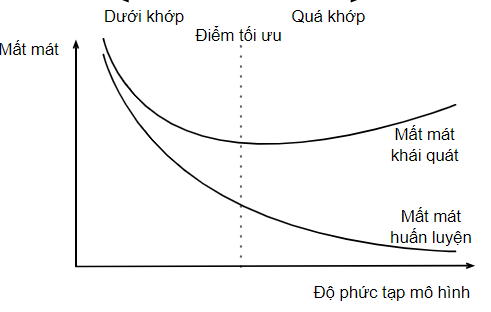

In [7]:
from d2l import mxnet as d2l
from mxnet import gluon, np, npx, init
from mxnet.gluon import nn
npx.set_np()

#### 1. Tạo ra tập dữ liệu
- Đầu tiên ta cần dữ liệu, cho x ta sẽ sử dụng đa thức bậc ba ở dưới để để tạo nhãn cho tập dữ liệu huấn luyện và kiểm tra:
- Số hạng nhiễu eps tuân theo phân phối chuẩn với giá trị trung bình bằng 0 và độ lệch chuẩn bằng 0.1. Ta sẽ tạo 100 mẫu cho mỗi tập huấn luyện và tập kiểm tra.

    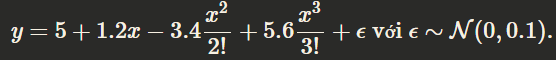

In [8]:
maxdegree = 20
n_train, n_test = 100, 100
true_w = np.zeros(maxdegree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(loc = 0, scale = 1, size = (n_train + n_test, 1))
features = np.random.shuffle(features)
print(features[:4], features.shape)

# Sử dụng reshape để chuyển shape từ (20, ) thành (1, 20)
poly_features = np.power(features, np.arange(maxdegree).reshape(1, -1))
# Phép tính giai thừa được lập trình bằng hàm gamma với n! = gamma(n + 1)
poly_features = poly_features / (npx.gamma(np.arange(maxdegree) + 1).reshape(1, -1))
true_w = true_w.reshape(maxdegree, -1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
labels.shape

[[ 1.938011 ]
 [-0.7527278]
 [-0.8198357]
 [ 1.704309 ]] (200, 1)


(200, 1)

#### 2. Huấn luyện và kiểm tra mô hình
- Ta thiết lập hàm để tính giá trị mất mát của dữ liệu cho trước và hàm huấn luyện.

In [9]:
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        metric.add(loss(net(X), y).sum(), y.size)
    return metric[0] / metric[1]

In [10]:
def train(train_features, test_features, train_labels, test_labels, num_epochs = 2000):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()

    net.add(nn.Dense(1, use_bias=False))
    net.initialize()

    batch_size = min(10, train_labels.shape[0])

    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)

    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate' : 0.005})

    animator = d2l.Animator(
        xlabel= 'epochs', ylabel='loss', yscale= 'log', xlim = [1, num_epochs], ylim = [1e-5, 1e2],
        legend = ['train', 'test']
    )

    for epoch in range(1, num_epochs + 1):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if (epoch % 50 == 0):
            animator.add([epoch] * 2, [evaluate_loss(net, train_iter, loss),
                                   evaluate_loss(net, test_iter, loss)])
        
    return net
    

#### 3. Khớp hàm đa thức bậc ba dạng chuẩn
- Ta sẽ bắt đầu với việc sử dụng hàm đa thức bậc ba cùng bậc với hàm tạo dữu liệu.


weight: [[ 5.0034738  1.1675928 -3.3841515  5.6603813]]


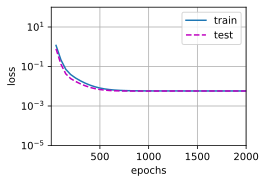

In [11]:
# Pick the first four dimensions from thje polynimial features
net = train(poly_features[:n_train, 0:4], poly_features[n_train:, 0:4],
      labels[:n_train], labels[n_train:])
print('weight:', net[0].weight.data().asnumpy())


#### 4. Khớp hàm tuyến tính (quá khớp)

weight: [[ 5.8225837  3.8740587 -5.522997 ]]


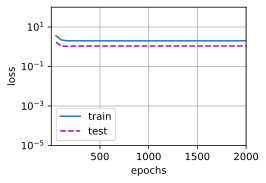

In [12]:
net2 = train(poly_features[:n_train, 0:3], poly_features[n_train:, 0:3], 
      labels[:n_train], labels[n_train:])
print('weight:', net2[0].weight.data().asnumpy())

#### 5. Thiếu dữ liệu huấn luyện (quá khớp)

weight: [[ 3.8070972e+00  7.2891754e-01  9.7582901e-01  4.8409340e-01
   1.4904118e-01  1.4150619e-02 -9.1160722e-03 -4.3265332e-02
  -5.9204817e-02  2.2525287e-03 -6.0753055e-02 -3.8816873e-02
   4.9880739e-02 -1.8271169e-02 -4.7303163e-02 -6.2284980e-02
   8.3555430e-03  5.7567604e-02  3.8283780e-02  5.3893268e-02]]


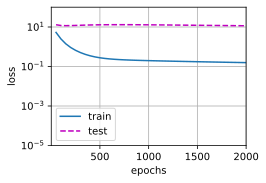

In [17]:
n_subset = 10  # Subset of data to train on
n_degree = 20  # Degree of polynomials
net3 = train(poly_features[:n_subset, 0:n_degree],
      poly_features[n_train:, 0:n_degree], labels[:n_subset],
      labels[n_train:])
print('weight:', net3[0].weight.data().asnumpy())